In [311]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ydata_profiling
import warnings
import xgboost as xgb

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import stats 

warnings.simplefilter(action="ignore", category=FutureWarning)

In [312]:
pd.set_option('display.max_columns', 50) #вывод всех столбцов датасета
pd.options.display.float_format = '{:,.2f}'.format #избавление от экспоненты

In [313]:
def accuracy_report(y_true, y_pred, make_plot=True):
    print('MSE: {:.3f}'.format(mse(y_true, y_pred)))
    print('RMSE: {:.3f}'.format(np.sqrt(mse(y_true, y_pred))))
    print('MAE: {:.3f}'.format(mae(y_true, y_pred)))
    if make_plot:
        plt.figure(figsize=(8,6))
        plt.scatter(y_true, y_pred)
        plt.xlabel('Reality')
        plt.ylabel('Prediction')
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')

# Теперь считаем файл целиком и проведем исследовательский анализ данных (EDA) при помощи библиотеки ydata_profiling

In [314]:
df_house = pd.read_csv('realty_data.csv')

In [315]:
profile = ydata_profiling.ProfileReport(df_house, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Экспортируем данный отчет в файл, это позволит более удобно работать с ним

In [316]:
profile.to_file("data_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Возьмем самыю последнюю цену на момент публикации

In [317]:
train_temp1 = df_house[df_house.drop('price', axis=1).duplicated(keep=False)]
train_temp2 = train_temp1.drop('price', axis=1).drop_duplicates(keep='last')  # Save only last
mask_duple_tag = np.invert(train_temp1.index.isin(train_temp2.index))  # Get difference index
df_house = df_house.drop(train_temp1.index[mask_duple_tag])

Заполним пропущенные значения

In [318]:
numeric_cols = df_house.select_dtypes(include=['number']).columns
print(numeric_cols)

Index(['period', 'price', 'postcode', 'lat', 'lon', 'total_square', 'rooms',
       'floor'],
      dtype='object')


In [319]:
non_numeric_cols = df_house.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)

Index(['product_name', 'address_name', 'object_type', 'city', 'settlement',
       'district', 'area', 'description', 'source'],
      dtype='object')


In [320]:
def check_pass_obj(df):
    if isinstance(df, pd.DataFrame):
        return True
    else:
        return False
    

def change_missing_values_non_numeric_by_const(df, cols_to_fill):
    if check_pass_obj(df):
        for col in cols_to_fill:
            df[col] = df[col].fillna('NA')
    else:
        raise TypeError("Data must be a Pandas DataFrame")
    

def change_missing_values_numeric_by_const(df, cols_to_fill):
    if check_pass_obj(df):
        for col in cols_to_fill:
            df[col] = df[col].fillna(0)
    else:
        raise TypeError("Data must be a Pandas DataFrame")
    

lst_numeric_for_fill = []
lst_non_numeric_for_fill = []

lst_input = list(df_house.columns)

for col in lst_input:
    if col in non_numeric_cols:
        lst_non_numeric_for_fill.append(col)
    if col in numeric_cols:
        lst_numeric_for_fill.append(col)
    if len(lst_non_numeric_for_fill) > 0:
        change_missing_values_non_numeric_by_const(df_house, lst_non_numeric_for_fill)
        change_missing_values_non_numeric_by_const(df_house, lst_non_numeric_for_fill)
    if len(lst_numeric_for_fill) > 0:
        change_missing_values_numeric_by_const(df_house, lst_numeric_for_fill)
        change_missing_values_numeric_by_const(df_house, lst_numeric_for_fill)

Изменим тип полей

In [321]:
def int8_type(number):
    if -128 <= number <= 127:
        return True
    return False


def int16_type(number):
    if -32768 <= number <= 32767:
        return True
    return False


def int32_type(number):
    if -2.1*10**9 <= number <= 2.1*10**9:
        return True
    return False


def int64_type(number):
    if -9.2*10**18 <= number <= 9.2*10**18:
        return True
    return False


def cast_numeric_column(df_col):
    max = df_col.max()
    min = df_col.min()
    if(int8_type(min) and int8_type(max)):
        return df_col.astype(np.int8)
    if(int16_type(min) and int16_type(max)):
        return df_col.astype(np.int16)
    if(int32_type(min) and int32_type(max)):
        return df_col.astype(np.int32)
    if(int64_type(min) and int64_type(max)):
        return df_col.astype(np.int64)


for col_name in numeric_cols:
   df_house[col_name] = cast_numeric_column(df_house[col_name])

Создадим новые колонки

In [322]:
def level_floor(floor):
    if floor <= 3:
        return 0
    elif floor <= 6:
        return 1
    else:
        return 2

In [323]:
df_house['is_studio'] = [1 if 'Студия' in row.product_name else 0 for row in df_house.itertuples()]

df_house['is_studio'] = df_house['is_studio'].astype('bool')  # замена типа данных на булев

df_house['floor_category'] = df_house['floor'].apply(level_floor)

In [324]:
df_house.isnull().sum()

product_name      0
period            0
price             0
postcode          0
address_name      0
lat               0
lon               0
object_type       0
total_square      0
rooms             0
floor             0
city              0
settlement        0
district          0
area              0
description       0
source            0
is_studio         0
floor_category    0
dtype: int64

In [325]:
sns.set(rc={'figure.figsize':(10,8)})
df_house.head().T

0  \
product_name                                  3-комнатная, 137 м²   
period                                                          0   
price                                                    63000000   
postcode                                                   127473   
address_name                         2-й Щемиловский переулок, 5а   
lat                                                            55   
lon                                                            37   
object_type                                              Квартира   
total_square                                                  137   
rooms                                                           3   
floor                                                           6   
city                                                       Москва   
settlement                                                     NA   
district                                           Тверской район   
area                                                           NA   
description     Просторная квартира свободной планировки с пан...   
source                                                       ЦИАН   
is_studio                                                   False   
floor_category                                                  1   

                                                                1  \
product_name                                      Студия, 16,7 м²   
period                                                          0   
price                                                     3250000   
postcode                                                   108815   
address_name                                      Харлампиева, 46   
lat                                                            55   
lon                                                            37   
object_type                                              Квартира   
total_square                                                   16   
rooms                                                           0   
floor                                                           1   
city                                                       Москва   
settlement                                                     NA   
district                                 Филимонковское поселение   
area                                                           NA   
description                ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...   
source                                                    Домклик   
is_studio                                                    True   
floor_category                                                  0   

                                                                2  \
product_name                                   3-комнатная, 76 м²   
period                                                          0   
price                                                    16004680   
postcode                                                        0   
address_name                                    ЖК Прокшино, 8 к4   
lat                                                            55   
lon                                                            37   
object_type                                              Квартира   
total_square                                                   76   
rooms                                                           3   
floor                                                           6   
city                                                       Москва   
settlement                                                     NA   
district                                      Сосенское поселение   
area                                                           NA   
description     Apт.1684018. 0,01% - гибкая ипотека! Воспользу...   
source                                        Яндекс.Недвижимость   
is_studio                                                   

Text(0, 0.5, 'Цена')

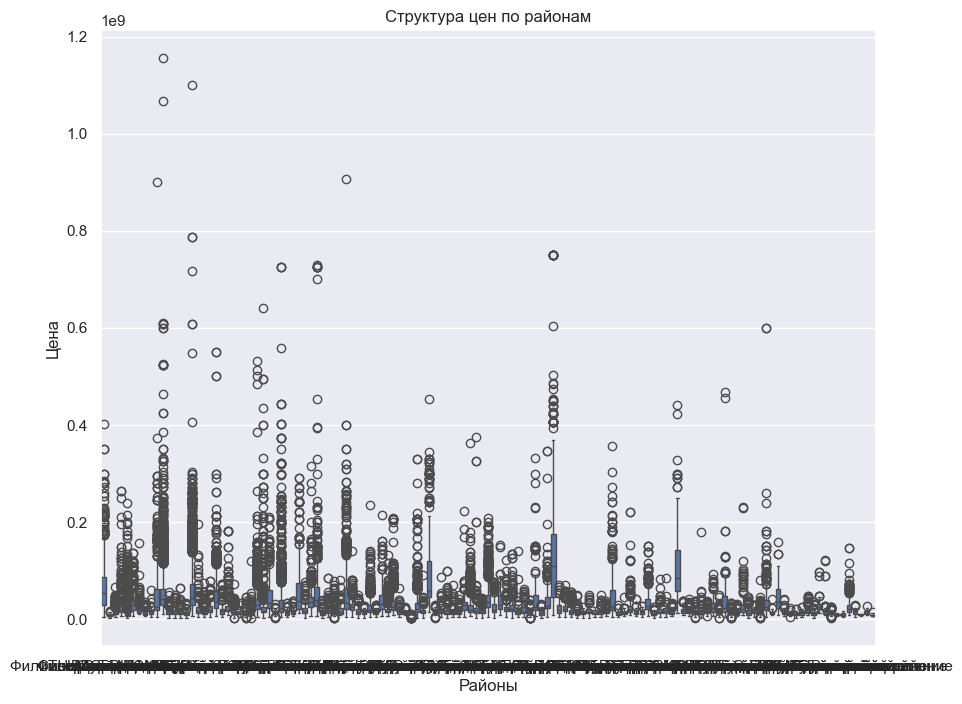

In [326]:
sns.boxplot(x = 'district', y = 'price', data = df_house)
plt.title("Структура цен по районам")
plt.xlabel("Районы")
plt.ylabel("Цена")

In [327]:
display(df_house.info()) #основная информация о датасете
display(df_house.describe()) #краткая информация о датасете
display(df_house.head()) #первые 5 строк датасета
display(df_house.tail()) #последние 5 строк датасета
display('#количество пропусков в датасете',
        df_house.isna().sum()) #количество пропусков в датасете
display('#процент пропусков от всего датасета',
        df_house.isna().mean().sort_values(ascending=False)*100) #процент пропусков от всего датасета
display('#кол-во явных дубликатов',
        df_house.duplicated().sum()) #кол-во явных дубликатов

<class 'pandas.core.frame.DataFrame'>
Index: 98348 entries, 0 to 98821
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_name    98348 non-null  object
 1   period          98348 non-null  int8  
 2   price           98348 non-null  int32 
 3   postcode        98348 non-null  int32 
 4   address_name    98348 non-null  object
 5   lat             98348 non-null  int8  
 6   lon             98348 non-null  int8  
 7   object_type     98348 non-null  object
 8   total_square    98348 non-null  int16 
 9   rooms           98348 non-null  int8  
 10  floor           98348 non-null  int8  
 11  city            98348 non-null  object
 12  settlement      98348 non-null  object
 13  district        98348 non-null  object
 14  area            98348 non-null  object
 15  description     98348 non-null  object
 16  source          98348 non-null  object
 17  is_studio       98348 non-null  bool  
 18  floor_categ

None

period            price   postcode       lat       lon  total_square  \
count 98,348.00        98,348.00  98,348.00 98,348.00 98,348.00     98,348.00   
mean       0.00    25,152,459.48 118,033.99     55.01     37.01         65.90   
std        0.00    36,137,313.33  30,036.21      0.09      0.09         48.91   
min        0.00     1,900,000.00       0.00     55.00     37.00          8.00   
25%        0.00    10,500,000.00 115,114.00     55.00     37.00         40.00   
50%        0.00    15,177,394.50 121,614.00     55.00     37.00         56.00   
75%        0.00    25,000,000.00 129,347.00     55.00     37.00         75.00   
max        0.00 1,155,219,000.00 143,989.00     56.00     38.00      2,070.00   

          rooms     floor  floor_category  
count 98,348.00 98,348.00       98,348.00  
mean       2.11      9.87            1.33  
std        1.11      8.20            0.83  
min        0.00      1.00            0.00  
25%        1.00      4.00            1.00  
50%        2.00      8.00            2.00  
75%        3.00     14.00            2.00  
max       15.00     66.00            2.00

product_name  period      price  postcode  \
0  3-комнатная, 137 м²       0   63000000    127473   
1      Студия, 16,7 м²       0    3250000    108815   
2   3-комнатная, 76 м²       0   16004680         0   
3   1-комнатная, 24 м²       0    7841776         0   
4  3-комнатная, 126 м²       0  120000000    121352   

                   address_name  lat  lon object_type  total_square  rooms  \
0  2-й Щемиловский переулок, 5а   55   37    Квартира           137      3   
1               Харлампиева, 46   55   37    Квартира            16      0   
2             ЖК Прокшино, 8 к4   55   37    Квартира            76      3   
3             ЖК Прокшино, 6 к2   55   37    Квартира            24      1   
4              Давыдковская, 18   55   37    Квартира           126      3   

   floor    city settlement                  district area  \
0      6  Москва         NA            Тверской район   NA   
1      1  Москва         NA  Филимонковское поселение   NA   
2      6  Москва         NA       Сосенское поселение   NA   
3     10  Москва         NA       Сосенское поселение   NA   
4     16  Москва         NA      Фили-Давыдково район   NA   

                                         description               source  \
0  Просторная квартира свободной планировки с пан...                 ЦИАН   
1             ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...              Домклик   
2  Apт.1684018. 0,01% - гибкая ипотека! Воспользу...  Яндекс.Недвижимость   
3  Продается однокомнатная квартира № 381 в новос...          Новострой-М   
4  Шикарное предложение!\nПродаётся трёхкомнатная...              Домклик   

   is_studio  floor_category  
0      False               1  
1       True               0  
2      False               1  
3      False               2  
4      False               2

product_name  period     price  postcode  \
98817    2-комнатная, 42 м²       0  12183528    125212   
98818  2-комнатная, 63,5 м²       0  34925000    129090   
98819  1-комнатная, 34,4 м²       0  10000000    117534   
98820    3-комнатная, 56 м²       0  15999000    109518   
98821  2-комнатная, 55,1 м²       0  16750000    109316   

                          address_name  lat  lon object_type  total_square  \
98817    Кронштадтский бульвар, 9 к1/3   55   37    Квартира            42   
98818       Олимпийский проспект, вл10   55   37    Квартира            63   
98819        Чертановская улица, 53 к1   55   37    Квартира            34   
98820    1-й Грайвороновский проезд, 3   55   37    Квартира            56   
98821  Волгоградский проспект, 32/3 к6   55   37    Квартира            55   

       rooms  floor    city settlement               district area  \
98817      2      8  Москва         NA      Головинский район   NA   
98818      2      3  Москва         NA        Мещанский район   NA   
98819      1      3  Москва         NA  Чертаново Южное район   NA   
98820      3     11  Москва         NA     Текстильщики район   NA   
98821      2     17  Москва         NA     Южнопортовый район   NA   

                                             description               source  \
98817  Продаётся 2-комн.квартира площадью 42.00 кв.м ...  Яндекс.Недвижимость   
98818  С 1 октября повышение цен на 5% на апартаменты...                 ЦИАН   
98819  Продажа идеальной однокомнатной квартиры. Безу...              Домклик   
98820  Новостройка! Евротрешка , две раздельная комна...              Домклик   
98821  !Двушка в бизнес-классе с шикарной планировкой...                 ЦИАН   

       is_studio  floor_category  
98817      False               2  
98818      False               0  
98819      False               0  
98820      False               2  
98821      False               2

'#количество пропусков в датасете'

product_name      0
period            0
price             0
postcode          0
address_name      0
lat               0
lon               0
object_type       0
total_square      0
rooms             0
floor             0
city              0
settlement        0
district          0
area              0
description       0
source            0
is_studio         0
floor_category    0
dtype: int64

'#процент пропусков от всего датасета'

product_name     0.00
floor            0.00
is_studio        0.00
source           0.00
description      0.00
area             0.00
district         0.00
settlement       0.00
city             0.00
rooms            0.00
period           0.00
total_square     0.00
object_type      0.00
lon              0.00
lat              0.00
address_name     0.00
postcode         0.00
price            0.00
floor_category   0.00
dtype: float64

'#кол-во явных дубликатов'

2

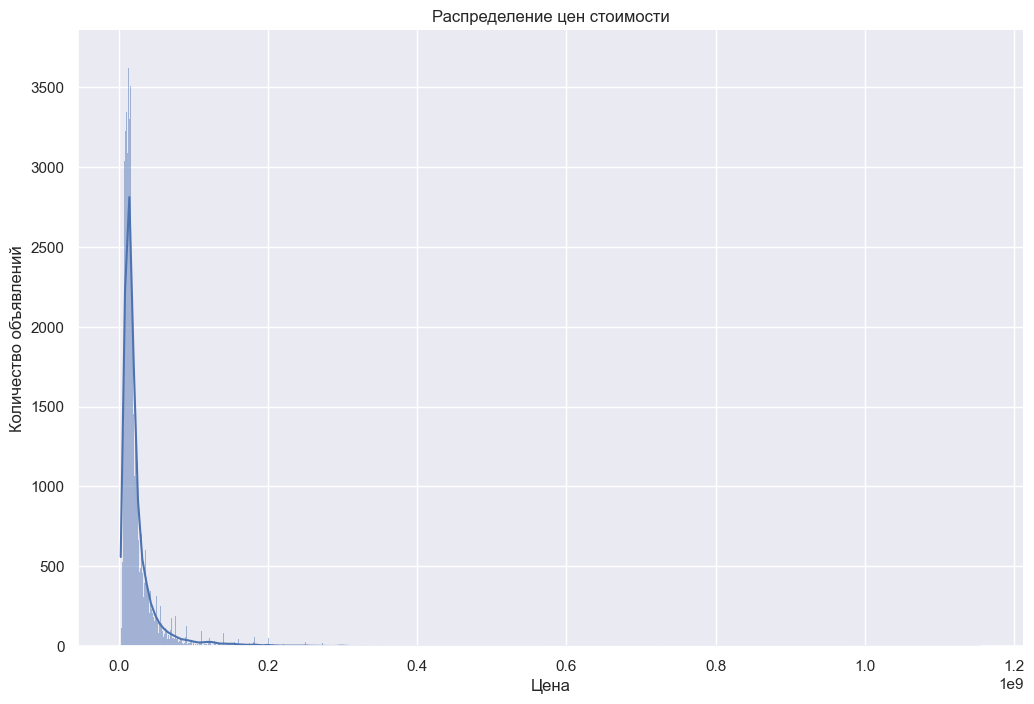

In [328]:
sns_plot = sns.displot(df_house['price'], kde = True, height = 7, aspect = 1.5)
plt.title("Распределение цен стоимости");
plt.xlabel("Цена");
plt.ylabel("Количество объявлений");

In [329]:
df_house.settlement = df_house.settlement.str.replace(
    '\xa0', ' ') #замена не правельных значений \xa0
df_house.settlement = df_house.settlement.str.replace(
    'д.', 'деревня') #замена на однотипные значнеия
df_house.settlement = df_house.settlement.str.replace(
    'дп.', 'дачный посёлок') #замена на однотипные значнеия
df_house.settlement = df_house.settlement.str.replace(
    'пос.', 'посёлок') #замена на однотипные значнеия
df_house.settlement = df_house.settlement.str.replace(
    'рп.', 'рабочий посёлок') #замена на однотипные значнеия
df_house.settlement = df_house.settlement.str.replace(
    'с.', 'село') #замена на однотипные значнеия
df_house.settlement = df_house.settlement.str.replace(
    'ё', 'е') #замена на однотипные значнеия
sorted_settlement = set(df_house['settlement'].unique()) #уникальные значения
#в алфавитном порядке
display(len(sorted_settlement)) #кол-во уникальных значений после удаления дубликатов

display(sorted_settlement) #проверка

47

{'NA',
 'дачный поселок Красково',
 'дачный поселок Лесной Городок',
 'деревня Аристово',
 'деревня Болтино',
 'деревня Большие Жеребцы',
 'деревня Глухово',
 'деревня Жабкино',
 'деревня Марусино',
 'деревня Мисайлово',
 'деревня Мотяково',
 'деревня Мякинино',
 'деревня Островцы',
 'деревня Пирогово',
 'деревня Подолино',
 'деревня Путилково',
 'деревня Раздоры',
 'деревня Сабурово',
 'деревня Сапроново',
 'деревня Солманово',
 'деревня Сосенки',
 'поселок Битца',
 'поселок ВНИИССОК',
 'поселок Ильинское-Усово',
 'поселок Коммунарка',
 'поселок Марьино',
 'поселок Мебельной фабрики',
 'поселок Мирный',
 'поселок Нагорное',
 'поселок Отрадное',
 'поселок Развилка',
 'поселок подсобного хозяйства "Воскресенское"',
 'рабочий поселок Боброво',
 'рабочий поселок Бутово',
 'рабочий поселок Дрожжино',
 'рабочий поселок Заречье',
 'рабочий поселок Лопатино',
 'рабочий поселок Малаховка',
 'рабочий поселок Нахабино',
 'рабочий поселок Новоивановское',
 'рабочий поселок Октябрьский',
 'рабочий

In [330]:
df_house['locality_name'] = [row.settlement if pd.isnull(row.city) else row.city for row in df_house.itertuples()]

In [331]:
presorted_source = set(df_house['source'].unique()) #уникальные значения
#в алфавитном порядке для столбца "source"
display(df_house.source.nunique()) #кол-во значений в столбце
display(presorted_source)

4

{'Домклик', 'Новострой-М', 'ЦИАН', 'Яндекс.Недвижимость'}

'#общая площадь'

count   98,348.00
mean        65.90
std         48.91
min          8.00
25%         40.00
50%         56.00
75%         75.00
max      2,070.00
Name: total_square, dtype: float64

'#цена'

count          98,348.00
mean       25,152,459.48
std        36,137,313.33
min         1,900,000.00
25%        10,500,000.00
50%        15,177,394.50
75%        25,000,000.00
max     1,155,219,000.00
Name: price, dtype: float64

'#число комнат'

count   98,348.00
mean         2.11
std          1.11
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         15.00
Name: rooms, dtype: float64

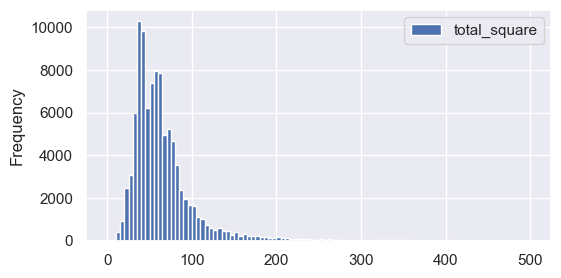

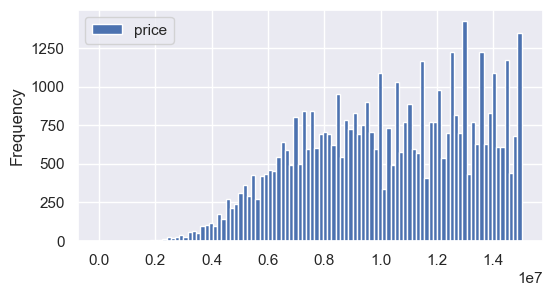

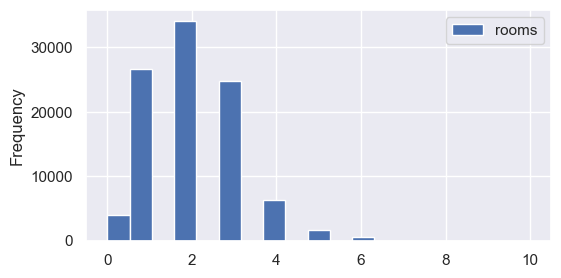

In [332]:
#общая площадь
df_house.plot(y = 'total_square', kind = 'hist', bins = 100, grid=True, figsize = (6,3), range = (0,500))
display('#общая площадь',
        df_house['total_square'].describe())
#цена
df_house.plot(y = 'price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (6,3))
display('#цена',
        df_house['price'].describe())

#число комнат
df_house.plot(y = 'rooms', kind = 'hist',range=(0,10), bins = 19, grid=True, figsize = (6,3))
display('#число комнат',
        df_house['rooms'].describe())

mean  count         median
total_square                                     
220          136,143,492.47     43 125,000,000.00
173          125,747,003.46     57 120,000,000.00
200          110,241,308.33    109 115,000,000.00
170          113,439,872.85    100 114,313,500.00
165          109,121,889.71     69 113,819,940.00
...                     ...    ...            ...
15             4,577,876.77    109   4,100,000.00
12             4,117,194.89     55   4,030,000.00
14             4,235,711.13    135   3,950,000.00
11             3,617,081.98     61   3,400,000.00
10             3,279,560.00     50   3,200,000.00

[162 rows x 3 columns]

mean  count           median
total_square                                         
8                2,783,333.33      6     2,725,000.00
9                2,948,846.15     13     2,990,000.00
10               3,279,560.00     50     3,200,000.00
11               3,617,081.98     61     3,400,000.00
12               4,117,194.89     55     4,030,000.00
...                       ...    ...              ...
1048           725,635,200.00      2   725,635,200.00
1050           725,635,200.00      2   725,635,200.00
1157           201,697,250.00      4   152,565,700.00
1167           291,750,000.00      1   291,750,000.00
2070         1,067,281,300.00      1 1,067,281,300.00

[493 rows x 3 columns]

0.8493081528513914

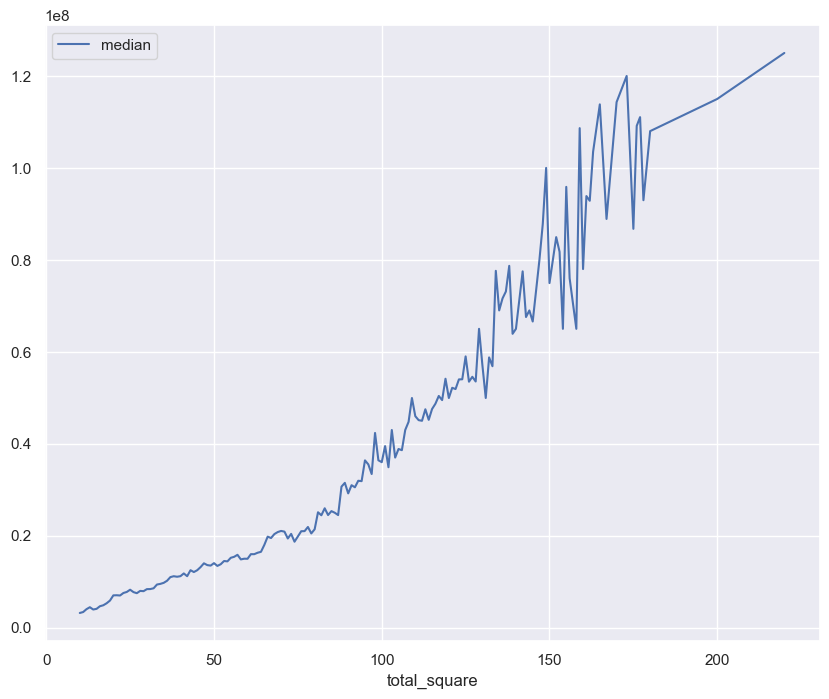

In [333]:
pivot_table_area = df_house.pivot_table(
    index = 'total_square', values = 'price', aggfunc = ['mean', 'count', 'median'])
pivot_table_area.columns = ['mean', 'count', 'median']
display(pivot_table_area.query(
    'count > 40').sort_values('median', ascending = False))
pivot_table_area.query(
    'count > 40').plot(y = 'median') #не включаем единичные случаи, чтобы картина была правдоподобнее


display(pivot_table_area)
df_house['total_square'].corr(df_house['price'])

На графике видна зависисмость между последней стоимостью и площадью помещения. Чем больше площадь помещения, тем выше цена. 
Коэффицент Пирсона равен 0.849, что говорит о достаточно высокой корреляции между площадью и ценой.

In [334]:
df_house['price_per_meter'] = df_house['price'] / df_house['total_square']

mean  count     median
rooms                             
6     584,998.09    649 544,226.40
7     575,439.68     45 531,787.17
5     556,887.51   1618 522,157.55
4     446,396.21   6376 390,476.19
1     319,895.21  26691 299,348.17
2     316,400.73  34142 283,783.78
3     334,025.95  24804 280,000.00
0     320,498.62   3975 273,913.04

mean  count     median
rooms                             
0     320,498.62   3975 273,913.04
1     319,895.21  26691 299,348.17
2     316,400.73  34142 283,783.78
3     334,025.95  24804 280,000.00
4     446,396.21   6376 390,476.19
5     556,887.51   1618 522,157.55
6     584,998.09    649 544,226.40
7     575,439.68     45 531,787.17
8     585,970.34     23 553,892.22
9     607,323.32     11 623,052.96
10    740,995.05      8 728,326.02
11    875,796.18      1 875,796.18
12    595,122.78      2 595,122.78
13    691,081.14      1 691,081.14
14    691,081.14      1 691,081.14
15    581,078.31      1 581,078.31

0.2056814471440878

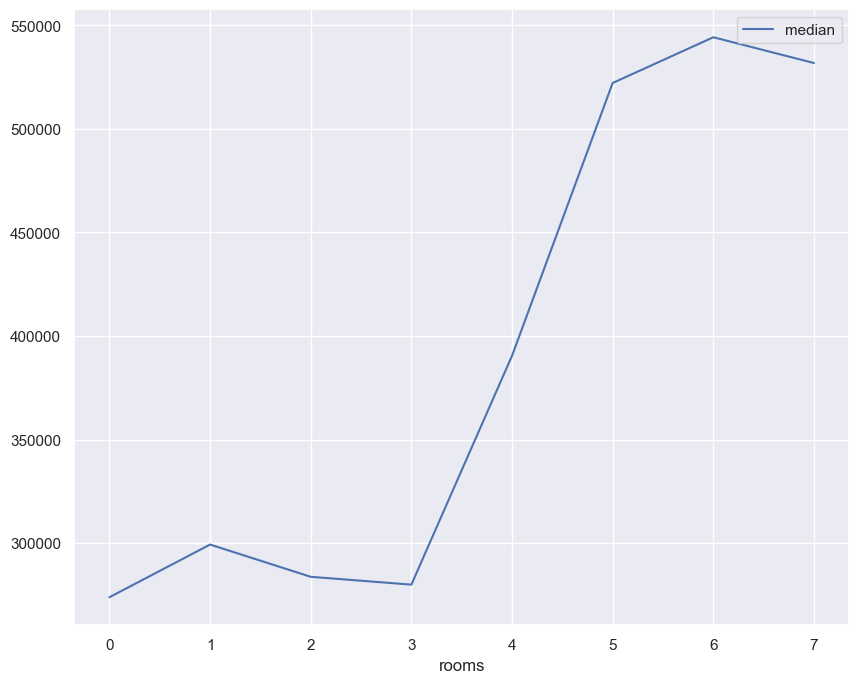

In [335]:
pivot_table_area = df_house.pivot_table(
    index = 'rooms', values = 'price_per_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_area.columns = ['mean', 'count', 'median']

display(pivot_table_area.query(
    'count > 30').sort_values('median', ascending = False))
pivot_table_area.query(
    'count > 30').plot(y = 'median') #не включаем единичные случаи, чтобы картина была правдоподобнее


display(pivot_table_area)
df_house['rooms'].corr(df_house['price_per_meter'])

На данном графике видно, что цена за квадратный метр уменьшается, приближаясь к отметке в "3 комнаты", затем цена за квадратный метр опять возрастает. Коэффицент Пирсона, равный 0,210 говорит о том, что нет прямой зависимости между показателем цены за квадратный метр и числом комнат в квартире.

0.13322198099249755

mean  count     median
floor                             
1     265,186.85   5423 242,500.00
62    261,709.12      2 261,709.12
66    275,220.89      1 275,220.89
2     328,473.78   9038 279,687.50
12    321,659.82   3638 281,707.84

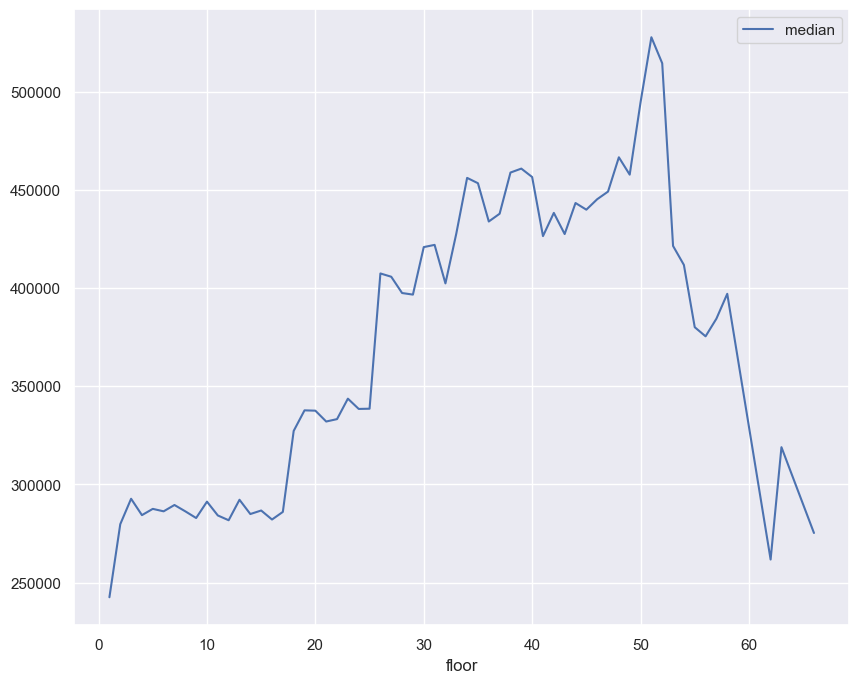

In [336]:
pivot_table_floor = df_house.pivot_table(
    index = 'floor', values = 'price_per_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor.columns = ['mean', 'count', 'median'] #избавление от мультииндекса
pivot_table_floor.plot(y = 'median') #график по медиане

display(df_house['floor'].corr(df_house['price_per_meter'])) #кореляция
pivot_table_floor.sort_values(by='median').head() #поиск аномалий

 Корреляция между этажом и ценой существует, но небольшая, это доказывает коэффицент Пирсона, который равен 0,133. Первый этаж является самым дешевым. Последние этажи дороже первых. Дорогими являются 50+ этажи. 

In [337]:
top_10 = df_house.groupby('city').count().sort_values(by='price', ascending=False).head(10)
display(top_10)

product_name  period  price  postcode  address_name    lat  \
city                                                                      
Москва              72724   72724  72724     72724         72724  72724   
NA                   6889    6889   6889      6889          6889   6889   
Балашиха             2908    2908   2908      2908          2908   2908   
Химки                2329    2329   2329      2329          2329   2329   
Люберцы              1964    1964   1964      1964          1964   1964   
Красногорск          1769    1769   1769      1769          1769   1769   
Мытищи               1708    1708   1708      1708          1708   1708   
Одинцово             1247    1247   1247      1247          1247   1247   
Королёв               980     980    980       980           980    980   
Котельники            897     897    897       897           897    897   

               lon  object_type  total_square  rooms  floor  settlement  \
city                                                                      
Москва       72724        72724         72724  72724  72724       72724   
NA            6889         6889          6889   6889   6889        6889   
Балашиха      2908         2908          2908   2908   2908        2908   
Химки         2329         2329          2329   2329   2329        2329   
Люберцы       1964         1964          1964   1964   1964        1964   
Красногорск   1769         1769          1769   1769   1769        1769   
Мытищи        1708         1708          1708   1708   1708        1708   
Одинцово      1247         1247          1247   1247   1247        1247   
Королёв        980          980           980    980    980         980   
Котельники     897          897           897    897    897         897   

             district   area  description  source  is_studio  floor_category  \
city                                                                           
Москва          72724  72724        72724   72724      72724           72724   
NA               6889   6889         6889    6889       6889            6889   
Балашиха         2908   2908         2908    2908       2908            2908   
Химки            2329   2329         2329    2329       2329            2329   
Люберцы          1964   1964         1964    1964       1964            1964   
Красногорск      1769   1769         1769    1769       1769            1769   
Мытищи           1708   1708         1708    1708       1708            1708   
Одинцово         1247   1247         1247    1247       1247            1247   
Королёв           980    980          980     980        980             980   
Котельники        897    897          897     897        897             897   

             locality_name  price_per_meter  
city                                         
Москва               72724            72724  
NA                    6889             6889  
Балашиха              2908             2908  
Химки                 2329             2329  
Люберцы               1964             1964  
Красногорск           1769             1769  
Мытищи                1708             1708  
Одинцово              1247             1247  
Королёв                980              980  
Котельники             897              897

In [338]:
top_10 = df_house.groupby('settlement').count().sort_values(by='price', ascending=False).head(10)
display(top_10)

product_name  period  price  postcode  \
settlement                                                              
NA                                     91459   91459  91459     91459   
поселок Коммунарка                       627     627    627       627   
деревня Путилково                        496     496    496       496   
поселок Развилка                         364     364    364       364   
рабочий поселок Дрожжино                 337     337    337       337   
рабочий поселок Новоивановское           281     281    281       281   
рабочий поселок Нахабино                 260     260    260       260   
рабочий поселок Лопатино                 259     259    259       259   
поселок Нагорное                         227     227    227       227   
рабочий поселок Боброво                  220     220    220       220   

                                address_name    lat    lon  object_type  \
settlement                                                                
NA                                     91459  91459  91459        91459   
поселок Коммунарка                       627    627    627          627   
деревня Путилково                        496    496    496          496   
поселок Развилка                         364    364    364          364   
рабочий поселок Дрожжино                 337    337    337          337   
рабочий поселок Новоивановское           281    281    281          281   
рабочий поселок Нахабино                 260    260    260          260   
рабочий поселок Лопатино                 259    259    259          259   
поселок Нагорное                         227    227    227          227   
рабочий поселок Боброво                  220    220    220          220   

                                total_square  rooms  floor   city  district  \
settlement                                                                    
NA                                     91459  91459  91459  91459     91459   
поселок Коммунарка                       627    627    627    627       627   
деревня Путилково                        496    496    496    496       496   
поселок Развилка                         364    364    364    364       364   
рабочий поселок Дрожжино                 337    337    337    337       337   
рабочий поселок Новоивановское           281    281    281    281       281   
рабочий поселок Нахабино                 260    260    260    260       260   
рабочий поселок Лопатино                 259    259    259    259       259   
поселок Нагорное                         227    227    227    227       227   
рабочий поселок Боброво                  220    220    220    220       220   

                                 area  description  source  is_studio  \
settlement                                                              
NA                              91459        91459   91459      91459   
поселок Коммунарка                627          627     627        627   
деревня Путилково                 496          496     496        496   
поселок Развилка                  364          364     364        364   
рабочий поселок Дрожжино          337          337     337        337   
рабочий поселок Новоивановское    281          281     281        281   
рабочий поселок Нахабино          260          260     260        260   
рабочий поселок Лопатино          259          259     259        259   
поселок Нагорное                  227          227     227        227   
рабочий поселок Боброво           220          220     220        220   

                                floor_category  locality_name  price_per_meter  
settlement                                                                      
NA                                       91459          91459            91459  
поселок Коммунарка                         627            627              627  
деревня Путилково                          496            496              496  
поселок Развилка       

In [339]:
df_v1 = df_house.drop(columns=["city","settlement","district","source","postcode","product_name","period","address_name","object_type", "area", "description", "price_per_meter"])

In [340]:
df_v1.head()

price  lat  lon  total_square  rooms  floor  is_studio  floor_category  \
0   63000000   55   37           137      3      6      False               1   
1    3250000   55   37            16      0      1       True               0   
2   16004680   55   37            76      3      6      False               1   
3    7841776   55   37            24      1     10      False               2   
4  120000000   55   37           126      3     16      False               2   

  locality_name  
0        Москва  
1        Москва  
2        Москва  
3        Москва  
4        Москва

In [341]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98348 entries, 0 to 98821
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   price           98348 non-null  int32 
 1   lat             98348 non-null  int8  
 2   lon             98348 non-null  int8  
 3   total_square    98348 non-null  int16 
 4   rooms           98348 non-null  int8  
 5   floor           98348 non-null  int8  
 6   is_studio       98348 non-null  bool  
 7   floor_category  98348 non-null  int64 
 8   locality_name   98348 non-null  object
dtypes: bool(1), int16(1), int32(1), int64(1), int8(4), object(1)
memory usage: 3.3+ MB


In [342]:
df_house.shape

(98348, 21)

<Axes: >

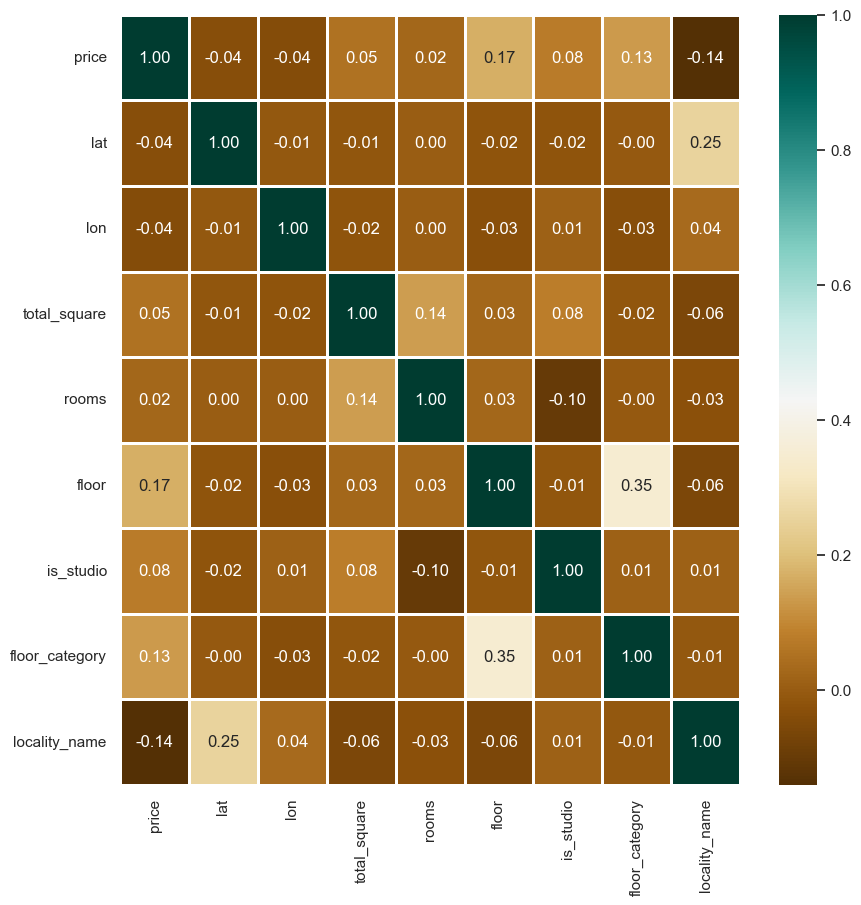

In [343]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_v1.apply(lambda x: x.factorize()[0]).corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

In [344]:
enc = LabelEncoder()
df_v1['locality_name'] = enc.fit_transform(df_v1['locality_name'])

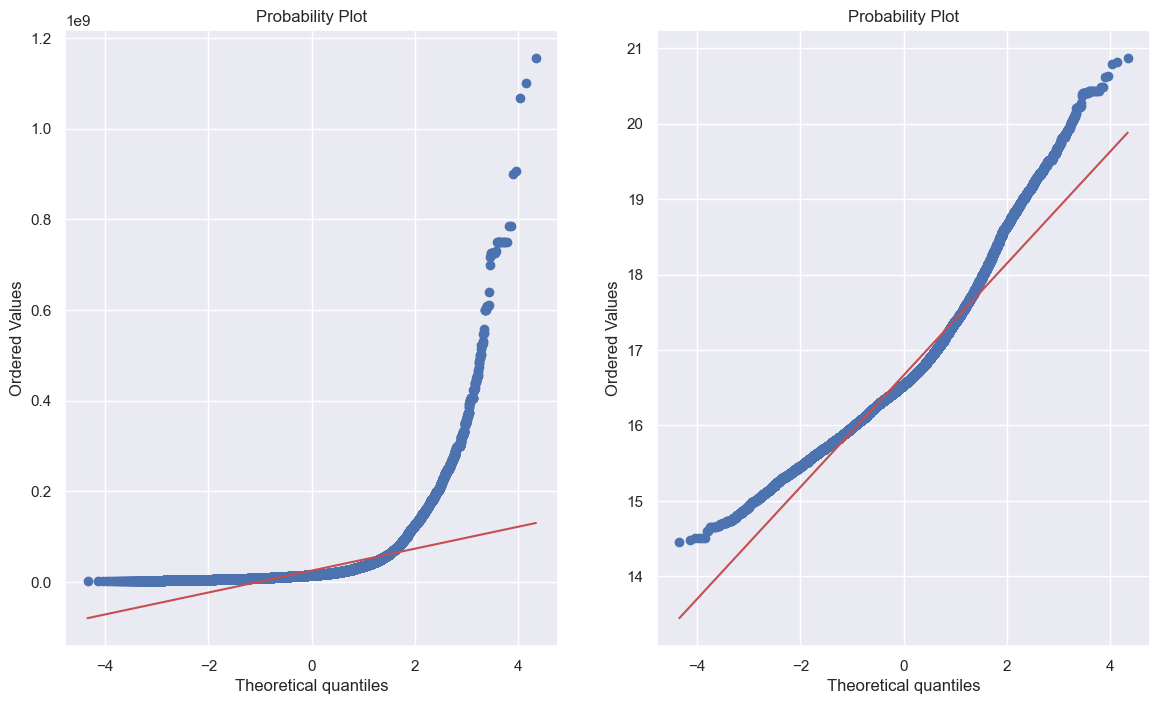

In [345]:
fig = plt.figure(figsize = (14,8))

# Распределение на необработанных данных
fig.add_subplot(1,2,1)
res = stats.probplot(df_v1['price'], plot=plt)

# Распределение при условии, что мы прологарифмировали 'price'
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_v1['price']), plot=plt)

In [346]:
df_v1['price'] = np.log1p(df_v1['price'])

In [347]:
X, y = df_v1.drop("price", axis=1), df_v1['price']

In [348]:
X

lat  lon  total_square  rooms  floor  is_studio  floor_category  \
0       55   37           137      3      6      False               1   
1       55   37            16      0      1       True               0   
2       55   37            76      3      6      False               1   
3       55   37            24      1     10      False               2   
4       55   37           126      3     16      False               2   
...    ...  ...           ...    ...    ...        ...             ...   
98817   55   37            42      2      8      False               2   
98818   55   37            63      2      3      False               0   
98819   55   37            34      1      3      False               0   
98820   55   37            56      3     11      False               2   
98821   55   37            55      2     17      False               2   

       locality_name  
0                 12  
1                 12  
2                 12  
3                 12  
4                 12  
...              ...  
98817             12  
98818             12  
98819             12  
98820             12  
98821             12  

[98348 rows x 8 columns]

In [349]:
y

0       17.96
1       14.99
2       16.59
3       15.87
4       18.60
         ... 
98817   16.32
98818   17.37
98819   16.12
98820   16.59
98821   16.63
Name: price, Length: 98348, dtype: float64

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024, test_size=0.25)

In [351]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

MSE: 0.201
RMSE: 0.448
MAE: 0.331


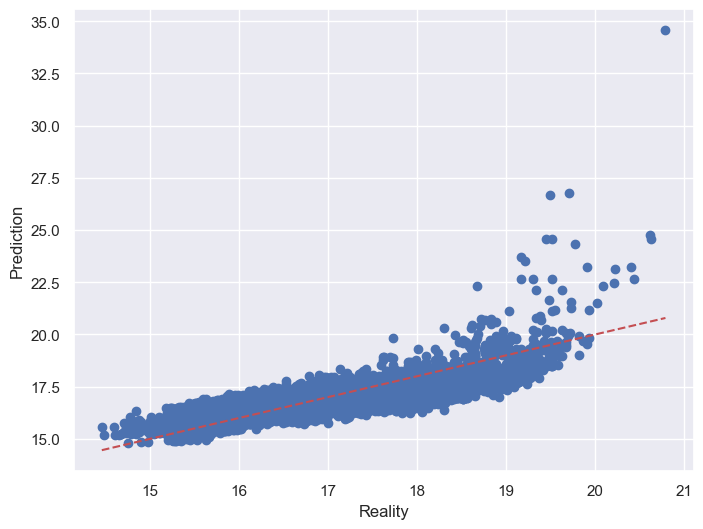

In [352]:
accuracy_report(y_test, lr.predict(X_test))

MSE: 0.201
RMSE: 0.448
MAE: 0.331


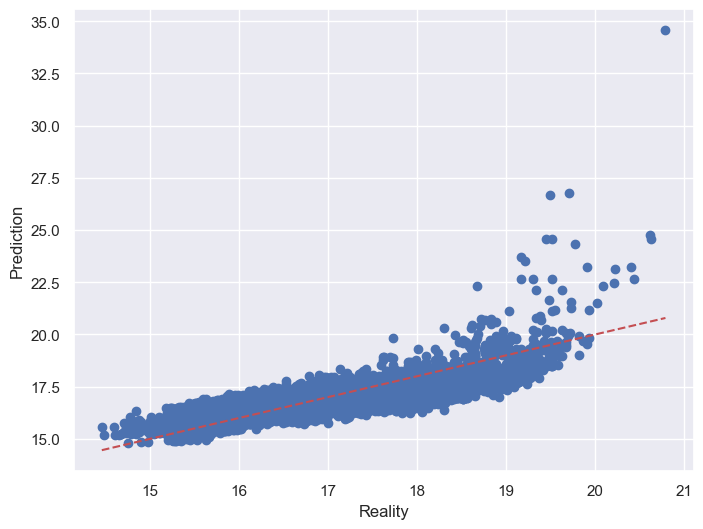

In [353]:
model = LinearRegression()
model.fit(X_train, y_train)

accuracy_report(y_test, model.predict(X_test))

In [354]:
ridge_cv = RidgeCV(alphas = (0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
ridge_cv.fit(X, y)

RidgeCV(alphas=(0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))

MSE: 0.200
RMSE: 0.448
MAE: 0.331


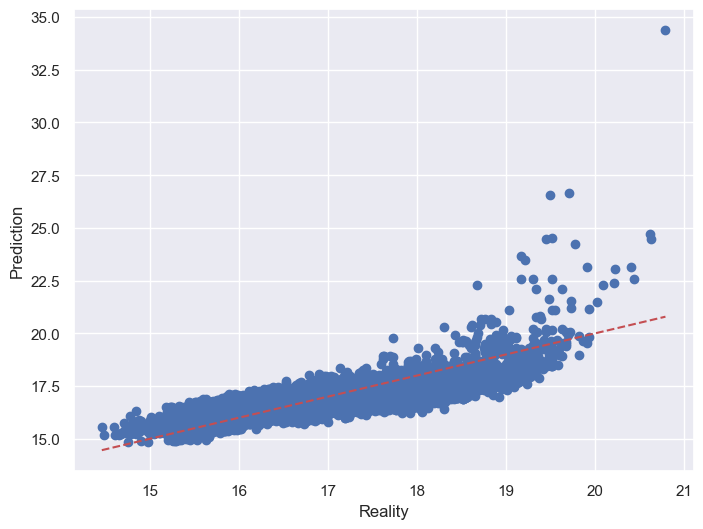

In [355]:
accuracy_report(y_test, ridge_cv.predict(X_test))

In [356]:
model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.2)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=340, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

MSE: 0.080
RMSE: 0.283
MAE: 0.214


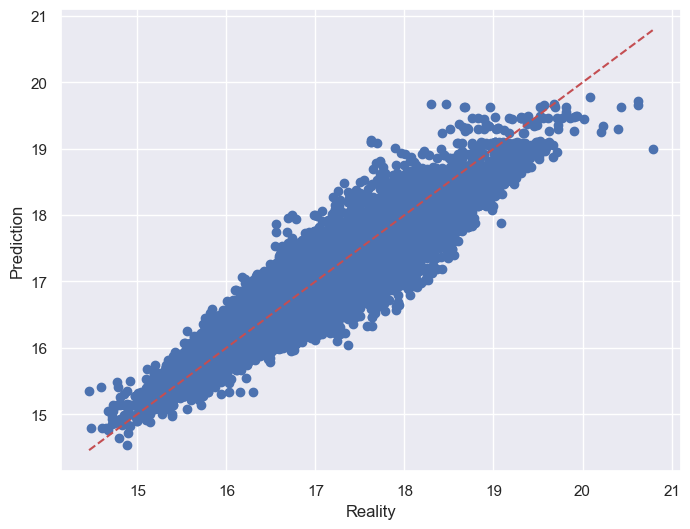

In [357]:
accuracy_report(y_test, model_xgb.predict(X_test))